In [1]:
import pandas as pd
import pickle
import os
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
path_to_processed_dataset_folder = '/home/shoaib/gnn/gcn/datasets'

In [3]:
if os.path.exists(path_to_processed_dataset_folder):
  print("Directory exists")
else:
  print("Directory not exists")

Directory exists


In [4]:
%pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.utils import add_self_loops, coalesce
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from torch_geometric.utils import index_to_mask
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
torch.manual_seed(0)
np.random.seed(0)

In [7]:
# Read the CSV files into DataFrames
user_df = pd.read_csv(f'{path_to_processed_dataset_folder}/user_features_processed.csv', header = 0)
news_df = pd.read_csv(f'{path_to_processed_dataset_folder}/news_features_processed.csv', header = 0)

# Remove duplicates based on the first column
user_df = user_df.drop_duplicates(subset=[user_df.columns[0]])
news_df = news_df.drop_duplicates(subset=[news_df.columns[0]])

In [8]:
# Load user and news features, excluding the first column
user_features = user_df.values[:, 1:]
news_features = news_df.values[:, 1:]

In [9]:
# Get the usernames and newsnames
usernames = user_df.values[:, 0]
newsnames = news_df.values[:, 0]

# Create the username_to_index and newsname_to_index dictionaries
username_to_index = {username: index for index, username in enumerate(usernames)}
newsname_to_index = {filename: index + len(usernames) for index, filename in enumerate(newsnames)}

In [10]:
# Read the relationship file into a DataFrame
relationship_df = pd.read_csv(f'{path_to_processed_dataset_folder}/relationship_user_and_news_v2.csv')

# Remove duplicates based on the username
relationship_df = relationship_df.drop_duplicates(subset=['username'])

In [11]:
relationship_df

,username,filename,label,human_evaluation
0,JcKatherine,politifact13816,0.0,4
1,bjr1961,politifact13816,0.0,4
2,SherryAva,politifact13816,0.0,4
3,linnflux,politifact13816,0.0,4
4,po_murray,politifact13816,0.0,4
...,...,...,...,...
14530,Omwenga,politifact12721,1.0,3
14531,MarkPaleo,politifact12721,1.0,3
14532,einerdrake,politifact12721,1.0,4
14533,Corinne4Hillary,politifact12721,1.0,5


In [12]:
# Create adjacency matrix

#calculates the total number of nodes in the graph, which is the sum of the number of users (len(usernames)) and the number of news items (len(newsnames)).
num_nodes = len(usernames) + len(newsnames)

"""
initializes an adjacency matrix as a 2D NumPy array of zeros with shape (num_nodes, num_nodes).
This creates a square matrix with dimensions equal to the total number of nodes in the graph.
The matrix is initially filled with zeros, indicating that there are no edges between any pair of nodes.
"""

adjacency_matrix = np.zeros((num_nodes, num_nodes))

"""
iterates over the rows of the relationship_df DataFrame, which contains the relationships between users 
and news items. For each row, it gets the indices of the user and the news item in the username_to_index and newsname_to_index 
dictionaries, respectively. These indices correspond to the positions of the user and the news item in the adjacency matrix.
Finally, it sets the element of the adjacency matrix at the position (user_id, news_id) to 1, indicating that there is 
an edge between the user and the news item. This is done for every row in the relationship_df DataFrame, effectively filling 
in the adjacency matrix with the relationships between users and news items.
At the end of this code block, adjacency_matrix is a 2D NumPy array that represents the graph of users and news items. If there 
is a relationship between a user and a news item, the corresponding element in the adjacency matrix is 1; otherwise, it is 0.
"""

for _, row in relationship_df.iterrows():
    user_id = username_to_index[row['username']]
    news_id = newsname_to_index[row['filename']]
    adjacency_matrix[user_id, news_id] = 1



In [13]:
adjacency_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
# Initialize the edge attribute matrix with zeros
edge_attr_matrix = np.zeros((num_nodes, num_nodes))

# Fill the edge attribute matrix with human survey values
for _, row in relationship_df.iterrows():
    user_id = username_to_index[row['username']]
    news_id = newsname_to_index[row['filename']]
    survey_value = row['human_evaluation'] 
    edge_attr_matrix[user_id, news_id] = survey_value

# Convert the edge attribute matrix into a tensor
edge_attr_matrix = np.eye(num_nodes) + edge_attr_matrix  # Add self-loops
edge_attr = torch.tensor(edge_attr_matrix[edge_attr_matrix.nonzero()], dtype=torch.float, requires_grad=True)

# # Flatten the edge_attr tensor to make it 1D
# edge_attr = edge_attr.flatten()

In [43]:
# Load node attributes, adjacency matrix, and labels from .npy files
node_attributes = np.load(f'{path_to_processed_dataset_folder}/node_attributes.npy', allow_pickle = True)
adj = np.load(f'{path_to_processed_dataset_folder}/adjacency_matrix.npy', allow_pickle = True)
y = np.load(f'{path_to_processed_dataset_folder}/labels_v2.npy', allow_pickle = True)

In [16]:
node_attributes

array([[1.27, 11122.0, 11272.0, ..., 0.0, 0.0, 0.0],
       [1.06, 267.0, 1359.0, ..., 0.0, 0.0, 0.0],
       [1.33, 537.0, 409.0, ..., 0.0, 0.0, 0.0],
       ...,
       [14.511231890100216, 47.83230057107836, 14.0091382248733, ...,
        1.42, 0.94, 0.24],
       [13.5591, 45.29501831501835, 14.264175824175828, ..., 0.0, 0.0,
        1.01],
       [12.254254345995212, 61.67082158675014, 10.53875914973744, ...,
        1.4, 0.06, 2.02]], dtype=object)

In [53]:
# Convert adjacency matrix to edge index
edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)

# Convert node attributes to tensor
node_attributes = node_attributes.astype(np.float32)
x = torch.from_numpy(node_attributes).to(torch.float)

# Add self loops to the edge index
edge_index, _ = add_self_loops(edge_index, None)

# Coalesce the edge index
num_nodes = x.size(0)
edge_index, _ = coalesce(edge_index, None, num_nodes, num_nodes)

# Convert labels to tensor and pad with zeros
y = torch.from_numpy(y.squeeze()).to(torch.long)
#y = torch.cat((y, torch.zeros(num_nodes - y.size()[0], dtype=torch.long)))

# Create Data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [79]:
print(edge_index)
print(len(edge_index))
print(edge_index.shape[1])

tensor([[    0,     0,     1,  ..., 13337, 13338, 13339],
        [    0, 13202,     1,  ..., 13337, 13338, 13339]])
2
26494


In [78]:
edge_attr.shape[0]

26494

In [76]:
y.size

13340

In [77]:
x.size(1)

138

In [22]:
edge_index.shape

torch.Size([2, 26494])

In [55]:
train_per = 0.8  # Adjust as needed

y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(range(y.size), y.squeeze(),
                                                    test_size=1 - train_per - 0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=train_per / (train_per + 0.1), random_state=42)

train_index = torch.tensor(X_train, dtype=torch.long)
val_index = torch.tensor(X_val, dtype=torch.long)
test_index = torch.tensor(X_test, dtype=torch.long)

train_mask = index_to_mask(train_index, size=num_nodes)
val_mask = index_to_mask(val_index, size=num_nodes)
test_mask = index_to_mask(test_index, size=num_nodes)

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [24]:
print(y)

[2 2 2 ... 1 1 1]


In [80]:
print("Shape of x:", x.shape)
print("Shape of edge_index:", edge_index.shape)
print("Shape of edge_attr:", edge_attr.shape)


Shape of x: torch.Size([13340, 138])
Shape of edge_index: torch.Size([2, 26494])
Shape of edge_attr: torch.Size([26494])


In [118]:
from torch_scatter import scatter_add
class EdgeAttrSAGEConv(SAGEConv):
    def __init__(self, in_channels, out_channels):
        super(EdgeAttrSAGEConv, self).__init__(in_channels, out_channels)
        # Assuming edge_attr is 1-dimensional, if it's not, adjust the in_features accordingly
        self.edge_attr_lin = torch.nn.Linear(1, out_channels)

    def forward(self, x, edge_index, edge_attr):
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Multiply edge attributes by the node features before aggregation.
        row, col = edge_index
        edge_attr = self.edge_attr_lin(edge_attr.view(-1, 1))
        x_j = x[col] * edge_attr

        # Aggregate edge attributes using the 'add' operation.
        aggr_out = scatter_add(x_j, row, dim=0, dim_size=x.size(0))

        # Combine the aggregated edge attributes with the node features.
        out = self.propagate(edge_index, x=x, size=None)
        out += aggr_out

        return out

class SAGE(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(SAGE, self).__init__()
        self.conv1 = EdgeAttrSAGEConv(num_features, 128)
        self.conv2 = EdgeAttrSAGEConv(128, num_classes)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)

        return F.log_softmax(x, dim=-1)

In [70]:
num_classes = len(np.unique(y))  # Adjust as needed
num_classes

3

In [119]:

model = SAGE(num_features=x.size(1), num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
# # loss function optimization considering the weight distribution  

# from torch import device

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     weights = torch.tensor([200.0, 200.0, 0.1]).to(device)
#     loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], weight=weights)
#     loss.backward()
#     optimizer.step()
#     return loss.item()


# def test(mask):
#     model.eval()
#     with torch.no_grad():
#         logits = model(data)
#         preds = logits.max(dim=1)[1]
#         correct = preds[mask].eq(data.y[mask]).sum().item()
#         acc = correct / mask.sum().item()
#         return acc, preds[mask], data.y[mask]


In [120]:
# loss function optimization considering the only two classes 

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    
    # Create a mask for the fake and real news
    news_mask = (data.y[data.train_mask] == 0) | (data.y[data.train_mask] == 1)
    
    # Apply the mask to the output and labels
    out_news = out[data.train_mask][news_mask]
    labels_news = data.y[data.train_mask][news_mask]
    
    # Compute the loss only for the fake and real news
    loss = F.nll_loss(out_news, labels_news)
    
    loss.backward()
    optimizer.step()
    return loss.item()

def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.max(dim=1)[1]
        
        # Create a mask for the fake and real news
        news_mask = (data.y[mask] == 0) | (data.y[mask] == 1)
        
        # Apply the mask to the predictions and labels
        preds_news = preds[mask][news_mask]
        labels_news = data.y[mask][news_mask]
        
        correct = preds_news.eq(labels_news).sum().item()
        acc = correct / news_mask.sum().item()
        return acc, preds_news, labels_news


In [30]:
# # General training appraoch

# for epoch in range(1, 150):
#     loss = train()
#     train_acc, _, _ = test(data.train_mask)
#     val_acc, _, _ = test(data.val_mask)
#     test_acc, preds, labels = test(data.test_mask)
#     print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

In [121]:
# Best accuracy from epochs

best_acc = 0.0
best_epoch = 0
best_state_dict = None
patience = 100  # Number of epochs to wait for improvement before stopping
wait = 0

for epoch in range(1, 500):
    loss = train()
    train_acc, _, _ = test(data.train_mask)
    val_acc, _, _ = test(data.val_mask)
    test_acc, preds, labels = test(data.test_mask)
    
    # Save the model parameters if this epoch has the best accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        best_state_dict = model.state_dict()
        wait = 0  # Reset the counter
    else:
        wait += 1  # Increment the counter if no improvement
    
    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Stop training if no improvement for 'patience' epochs
    if wait >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

print(f'Best Val Acc: {best_acc} at Epoch: {best_epoch}')

RuntimeError: The size of tensor a (138) must match the size of tensor b (128) at non-singleton dimension 1

In [ ]:
path_to_saved_model_folder = '/home/shoaib/gnn/gcn/saved-models'
model_name = 'SAGE_model_human_evaluation_128'
path = f'{path_to_saved_model_folder}/{model_name}.pth'

torch.save(best_state_dict, path)

Final Test Accuracy: 0.7894736842105263
Final Test F1 Score: 0.7918128654970761
              precision    recall  f1-score   support

           0     0.6364    1.0000    0.7778         7
           1     1.0000    0.6667    0.8000        12

    accuracy                         0.7895        19
   macro avg     0.8182    0.8333    0.7889        19
weighted avg     0.8660    0.7895    0.7918        19



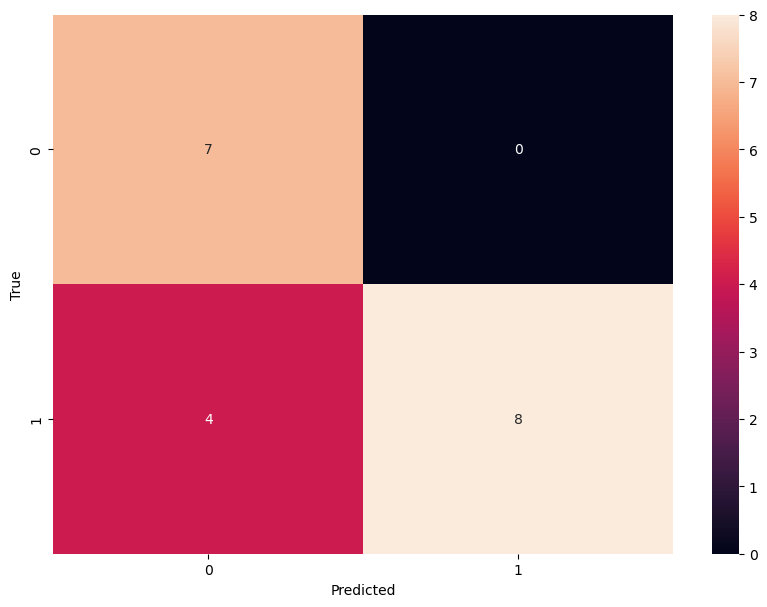

In [ ]:
# Make predictions with the best model

model.load_state_dict(torch.load(path))

model.eval()
with torch.no_grad():
    logits = model(data)
    preds = logits.max(dim=1)[1]

# Create a mask for the fake and real news
news_mask = ((data.y == 0) | (data.y == 1)) & data.test_mask

# Apply the mask to the labels and predictions
labels_news = data.y[news_mask]
preds_news = preds[news_mask]

accuracy = accuracy_score(labels_news.cpu(), preds_news.cpu())
f1 = f1_score(labels_news.cpu(), preds_news.cpu(), average='weighted')

print(f'Final Test Accuracy: {accuracy}')
print(f'Final Test F1 Score: {f1}')

report = classification_report(labels_news.cpu(), preds_news.cpu(), digits=4)
print(report)

cm = confusion_matrix(labels_news.cpu(), preds_news.cpu())

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()